In [ ]:
import sklearn
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt

# specify plot layout
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font_scale=0.6, font="serif")

### Loading the data

Let's load our dataset and print the description to understand the task we are going to solve.

In [ ]:
dataset = load_breast_cancer()
print(dataset["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Let's wrap the dataset with a pandas `DataFrame` to easily manipulate it.

In [ ]:
dataset_df = pd.DataFrame(data=dataset["data"], columns=dataset["feature_names"])
dataset_df["target"] = dataset["target"]
dataset["target_names"]

# We switch the values since 1 is now for malignant.
dataset_df["target"] = dataset_df["target"].apply(lambda val: 1 - val)

In [ ]:
dataset_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


Like in a real-world setting, let's divide our dataset in learning set and test set.

In [ ]:
X_learn, X_test, y_learn, y_test = train_test_split(dataset_df.drop(["target"], axis=1), dataset_df["target"], test_size=0.2)

dataset_learn = X_learn.copy()
dataset_learn["target"] = y_learn
dataset_learn.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
200,12.230,19.56,78.54,461.0,0.09586,0.08087,0.04187,0.04107,0.1979,0.06013,...,28.36,92.15,638.4,0.1429,0.20420,0.13770,0.10800,0.2668,0.08174,0
469,11.620,18.18,76.38,408.8,0.11750,0.14830,0.10200,0.05564,0.1957,0.07255,...,25.40,88.14,528.1,0.1780,0.28780,0.31860,0.14160,0.2660,0.09270,0
557,9.423,27.88,59.26,271.3,0.08123,0.04971,0.00000,0.00000,0.1742,0.06059,...,34.24,66.50,330.6,0.1073,0.07158,0.00000,0.00000,0.2475,0.06969,0
359,9.436,18.32,59.82,278.6,0.10090,0.05956,0.02710,0.01406,0.1506,0.06959,...,25.02,75.79,439.6,0.1333,0.10490,0.11440,0.05052,0.2454,0.08136,0
130,12.190,13.29,79.08,455.8,0.10660,0.09509,0.02855,0.02882,0.1880,0.06471,...,17.81,91.38,545.2,0.1427,0.25850,0.09915,0.08187,0.3469,0.09241,0


### Visualizing the data

In order to get more insights about the available data, let's visualize them to try to spot some pattern.

We can look at the features correlation or distribution of features according to the target we have to predict.

Text(0.5, 1.0, 'Correlation Matrix')

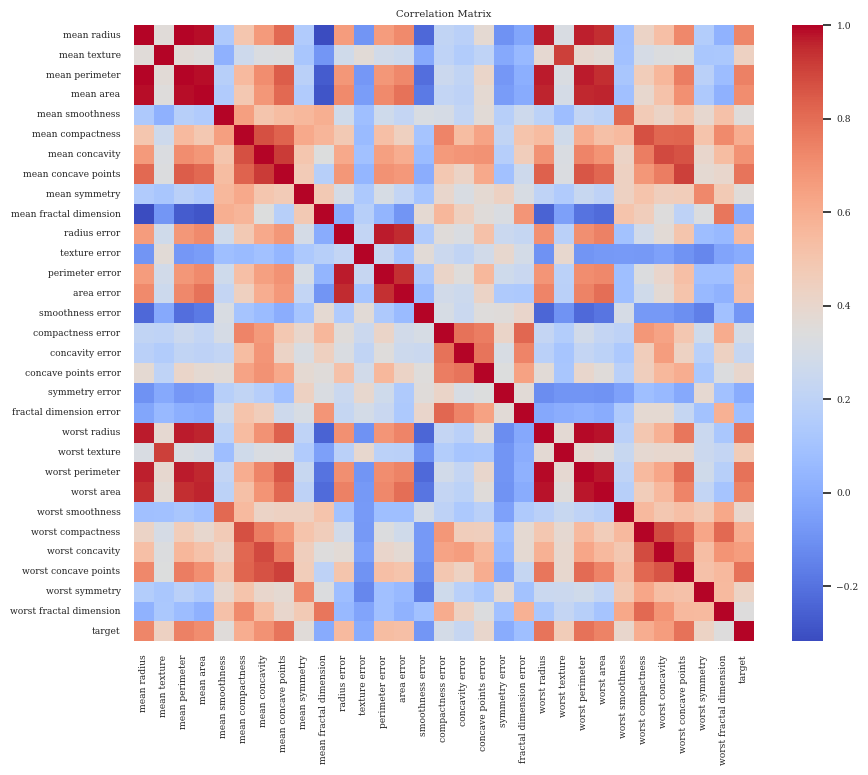

In [ ]:
plt.figure(figsize=(10, 8))
corr_matrix = dataset_learn.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')

Correlation plot represents how attributes are
correlated with each other.

- High correlation (close to 1 or -1) between two features can be a flag
for redundancy.

- Low correlation (close to 0) between a feature and the target can be a flag for uselessness.

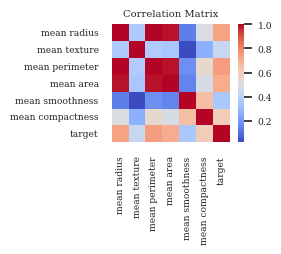

In [ ]:
plt.figure(figsize=(3, 2.5))
plt.gca().set_aspect('equal')
sns.heatmap(dataset_learn[dataset_learn.columns[:6].tolist() + ["target"]].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.pdf', transparent=True)
plt.show()

A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram.

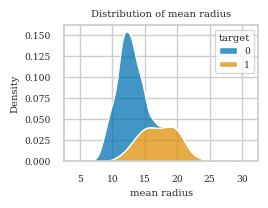

In [ ]:
plt.figure(figsize=(2.7, 2.1))
sns.kdeplot(dataset_learn, x='mean radius', hue="target", multiple="stack")
plt.title(f'Distribution of mean radius')
plt.tight_layout()
plt.savefig("kdeplot.pdf", transparent=True)
plt.show()

A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable.

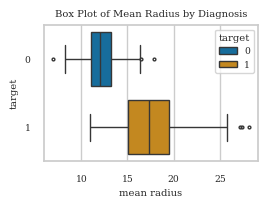

In [ ]:
plt.figure(figsize=(2.7, 2.1))
sns.boxplot(data=dataset_learn, x='mean radius', y='target', orient='h', fliersize=2, hue='target')
plt.title('Box Plot of Mean Radius by Diagnosis')
plt.tight_layout()
plt.savefig("boxplot.pdf", transparent=True)
plt.show()

## Data manipulation


Before starting manipulating data, let's first get our train/val splits from the learing dataset, in order to avoid information leakage from one split to the other. Also, it will be useful to perform hyper-parameter tuning on the validation and then select the best model based on this.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_learn, y_learn, test_size=0.2)

### Selecting the features

One scenario that can show, is that we want to select only some features of our dataset. Let's, for example, select the 10 most correlated features with the target in terms of absolute value of the correlation matrix.

However, additional to this simple approach there are more advanced ones from sklearn: https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [ ]:
sorted_indices = np.abs(corr_matrix["target"].values).argsort()[::-1]
most_important_features = corr_matrix.columns[sorted_indices[1:11]]
most_important_features

Index(['worst concave points', 'worst perimeter', 'mean concave points',
       'worst radius', 'mean perimeter', 'worst area', 'mean radius',
       'mean area', 'mean concavity', 'worst concavity'],
      dtype='object')

In [ ]:
X_train[most_important_features].head()

,worst concave points,worst perimeter,mean concave points,worst radius,mean perimeter,worst area,mean radius,mean area,mean concavity,worst concavity
52,0.06296,83.67,0.01349,13.10,75.71,527.2,11.940,437.6,0.01972,0.09203
90,0.06946,102.90,0.02957,16.11,94.57,803.7,14.620,662.7,0.03102,0.09189
459,0.04866,68.03,0.01043,10.67,61.68,349.9,9.755,290.9,0.01541,0.07190
277,0.12940,129.00,0.05843,19.96,120.90,1236.0,18.810,1102.0,0.08020,0.22100
136,0.06968,86.16,0.02600,13.33,74.72,546.7,11.710,423.6,0.03592,0.10460


In [ ]:
X_val[most_important_features].head()

,worst concave points,worst perimeter,mean concave points,worst radius,mean perimeter,worst area,mean radius,mean area,mean concavity,worst concavity
567,0.26500,184.60,0.15200,25.74,140.10,1821.0,20.60,1265.0,0.35140,0.9387
107,0.08442,85.56,0.01921,13.29,79.01,544.1,12.36,466.7,0.02643,0.1937
531,0.08120,87.00,0.02157,13.35,75.21,550.6,11.67,416.2,0.04200,0.2758
263,0.08568,115.90,0.02847,17.91,100.00,988.6,15.61,758.6,0.04209,0.2260
200,0.10800,92.15,0.04107,14.44,78.54,638.4,12.23,461.0,0.04187,0.1377


### Feature normalization

In [ ]:
X_learn.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,14.067121,19.174967,91.560374,648.496484,0.096541,0.104085,0.088188,0.048472,0.180759,0.062892,...,16.185145,25.519253,106.704132,867.170330,0.132657,0.253182,0.270304,0.114376,0.290495,0.084203
std,3.467907,4.270269,23.905703,345.775631,0.013868,0.052412,0.079754,0.038209,0.027419,0.007099,...,4.688908,6.085369,32.758989,544.272393,0.023003,0.157648,0.210179,0.065507,0.063345,0.017931
min,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.116700,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.650000,16.050000,74.720000,413.900000,0.086580,0.062985,0.029035,0.020335,0.161750,0.058045,...,12.980000,20.870000,83.795000,511.500000,0.116400,0.144100,0.109600,0.064075,0.247900,0.071835
50%,13.210000,18.770000,85.630000,541.600000,0.095860,0.092630,0.059290,0.032790,0.178200,0.061710,...,14.910000,25.260000,96.740000,683.400000,0.131200,0.211800,0.222000,0.101200,0.282700,0.080250
75%,15.815000,21.690000,104.200000,785.600000,0.105700,0.130450,0.131300,0.073720,0.195650,0.065950,...,19.025000,29.445000,126.500000,1091.500000,0.146350,0.333800,0.379500,0.161100,0.319000,0.092120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.311400,0.426400,0.191300,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,0.937900,1.252000,0.291000,0.663800,0.173000


We can see from the dataset statistics that feature values are not in the same range. Thus, let's perform some normalization to let the model assign the proper importance to each feature. (We select the 5 least correlated features just for the sake of better visualizing the improvement that standardizing the features brings).

              precision    recall  f1-score   support

           0       0.53      0.77      0.63        53
           1       0.08      0.03      0.04        38

    accuracy                           0.46        91
   macro avg       0.30      0.40      0.33        91
weighted avg       0.34      0.46      0.38        91



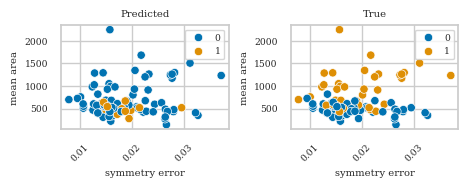

In [ ]:
# select the least correlated features with the target **just for the sake of visualization**
worst_columns = X_train.columns[(corr_matrix["target"].values).argsort()[:5]]

# define a KNN classifier and train on un-normalized features
knn = KNeighborsClassifier()
# scikit-learn adopts the idea of fit/predict -- first fit the model on the training data, then predict on validation/test
knn.fit(X_train[worst_columns], y_train)
y_pred = knn.predict(X_val[worst_columns])
# NB: within this paradigm is not possible to call `predict` without having fit the model first

# print values of classification metrics based on the prediction
print(classification_report(y_pred=y_pred, y_true=y_val))

# visualize how samples are distributed per-class considering features "smoothness error" and "worst radius"
fig, axes = plt.subplots(1, 2, figsize=(4.7, 1.9))
sns.scatterplot(data=X_val, x="symmetry error", y="mean area", hue=y_pred, ax=axes[0])
sns.scatterplot(data=X_val, x="symmetry error", y="mean area", hue=y_val.values, ax=axes[1])
axes[0].tick_params(axis='x', labelrotation=45)
axes[1].tick_params(axis='x', labelrotation=45)
axes[0].set_title("Predicted")
axes[1].set_title("True")
plt.tight_layout()
plt.savefig("before-norm.pdf")
plt.show()

Now, let's look at the effect of standardizing features:

              precision    recall  f1-score   support

           0       0.65      0.87      0.74        53
           1       0.65      0.34      0.45        38

    accuracy                           0.65        91
   macro avg       0.65      0.61      0.60        91
weighted avg       0.65      0.65      0.62        91



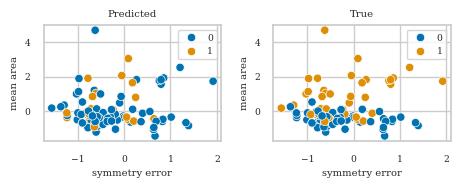

In [ ]:
# we use a StandardScaler that removes the mean and scales to unit variance
normalizer = StandardScaler()
X_train_norm = pd.DataFrame(normalizer.fit_transform(X_train), columns=X_train.columns)
X_val_norm = pd.DataFrame(normalizer.transform(X_val), columns=X_val.columns)

# define a new KNN classifier and train it on the standardized dataset
knn = KNeighborsClassifier()
knn.fit(X_train_norm[worst_columns], y_train)
y_pred = knn.predict(X_val_norm[worst_columns])
print(classification_report(y_pred=y_pred, y_true=y_val))

# again, visualize the distribution of the samples with scaled features
fig, axes = plt.subplots(1, 2, figsize=(4.7, 1.9))
sns.scatterplot(data=X_val_norm, x="symmetry error", y="mean area", hue=y_pred, ax=axes[0])
sns.scatterplot(data=X_val_norm, x="symmetry error", y="mean area", hue=y_val.values, ax=axes[1])
axes[0].set_title("Predicted")
axes[1].set_title("True")
plt.tight_layout()
plt.savefig("after-norm.pdf")

plt.show()

### Building our ML pipeline

Now, we have a sequence of steps we can perform when we are provided with a dataset -- namely, data visualization, data preprocessing and finally, model learning. The latter can be encapsulated in a pipeline.

Scikit-learn provide us with APIs to easily build pipelines. A pipeline is a sequence of transformations (`StandardScaler()`, ...) and a final estimator (`KNeighborsClassifier()`, ...). The transformations are applied to the data, and the final estimator is trained on the transformed data.

The pipeline is made of the `StandardScaler()` as the preprocessing step, followed by a `KNeighborsClassifier` as the estimator.

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('estimator', KNeighborsClassifier())])

# after defining a pipeline, it follows the same fit/predict pardigm
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print(classification_report(y_pred=y_pred, y_true=y_val))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        53
           1       1.00      0.87      0.93        38

    accuracy                           0.95        91
   macro avg       0.96      0.93      0.94        91
weighted avg       0.95      0.95      0.94        91



Note that, in `KNeighborsClassifier` we have the hyperparameter `k` that by default is set to `5`. However, we are still not choosing a proper values for it.

In [ ]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('estimator', KNeighborsClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'estimator': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform'}

How can we perform cross-validation to pick the $k$ that makes our model perform the best?

---

Here's also where scikit-learn comes in. It provides [APIs](https://scikit-learn.org/0.15/modules/grid_search.html#grid-search) for different kind of parameters search. Moreover, the estimator can be anything with the fit/predict paradigm. So we can feed it with out pipeline.

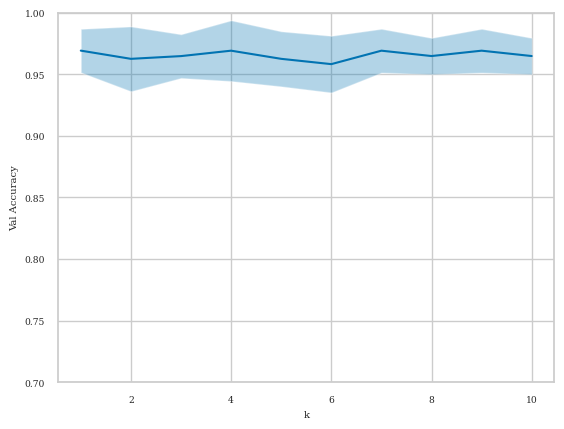

In [ ]:
# define the pipeline that will act as the estimator in the parameter search.
pipe = Pipeline([('scaler', MinMaxScaler()), ('estimator', KNeighborsClassifier())])

# declare the hyper-parameters to look for
parameters = {"estimator__n_neighbors": np.arange(1, 11).astype(int),
              "estimator__weights": ['uniform' , 'distance'],
              "estimator__metric": ["minkowski", "manhattan", "euclidean"]
              }

# instantiate the hyper-parameter selector as the RandomizedSearch
selector = RandomizedSearchCV(estimator=pipe, param_distributions=parameters, cv=10)
# start the
selector.fit(X_learn, y_learn)

# let's select the mean and std score
mean_scores = selector.cv_results_['mean_test_score']
std_scores = selector.cv_results_['std_test_score']

plt.plot(np.arange(len(mean_scores))+1, selector.cv_results_['mean_test_score'])
plt.fill_between(np.arange(len(mean_scores))+1, mean_scores + std_scores, mean_scores - std_scores, alpha=0.3)
plt.ylabel("Val Accuracy")
plt.xlabel("k")
plt.ylim(0.7, 1)
plt.savefig("cv_selector.pdf")

Let's look at the results of our randomized search.

In [ ]:
selector.best_params_

{'estimator__weights': 'distance',
 'estimator__n_neighbors': 5,
 'estimator__metric': 'minkowski'}

Now we have trained and selected our best model, let's look at the performance on the test set.

In [ ]:
y_test_pred = selector.predict(X_test)
print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

